# ***CONNECTING TO GOOGLE DRIVE***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# ***LIBRARIES***

In [ ]:
import torch
import os
import torch.nn as nn
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import torch.nn.functional as Func
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from scipy.stats import norm
from scipy.optimize import minimize
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D

#torch.manual_seed(123)
np.random.seed(123)

# ***MODEL***

In [ ]:
# Define the ABU activation function for the SABR PDE
class SinSoftplusActivation(nn.Module):
    def forward(self, input):
        new_act_f = 0.005*torch.sin(input) + 1*torch.nn.functional.softplus(input) + 0*torch.nn.functional.tanh(input) + 0.00*torch.nn.functional.gelu(input)
        return new_act_f

In [ ]:
class Alternative_FCN(nn.Module):
    def __init__(self):
        super(Alternative_FCN, self).__init__()
        self.bn1 = nn.BatchNorm1d(3)
        self.fc1 = nn.Linear(3, 200)
        self.act1 = SinSoftplusActivation()
        self.bn2 = nn.BatchNorm1d(200)
        self.fc2 = nn.Linear(200, 200)
        self.act2 = SinSoftplusActivation()
        self.bn3 = nn.BatchNorm1d(200)
        self.fc3 = nn.Linear(200, 200)
        self.act3 = SinSoftplusActivation()
        self.bn4 = nn.BatchNorm1d(200)
        self.fc4 = nn.Linear(200, 200)
        self.act4 = SinSoftplusActivation()
        self.bn5 = nn.BatchNorm1d(200)
        self.fc5 = nn.Linear(200, 200)
        self.act5 = SinSoftplusActivation()
        self.bn6 = nn.BatchNorm1d(200)
        self.fc6 = nn.Linear(200, 1)


    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        x = self.fc4(x)
        x = self.act4(x)
        x = self.fc5(x)
        x = self.act5(x)
        x = self.fc6(x)
        return x

# ***RANDOM DATASET GENERATION FOR PDE AND OTHER CONDITIONS***

Total points: 2190
Interior: 365 points (S∈[0.1, 148.6])
S=0 boundary: 365 points (σ∈[0.0, 0.5])
σ=0 boundary: 365 points (S∈[0.4, 149.8])


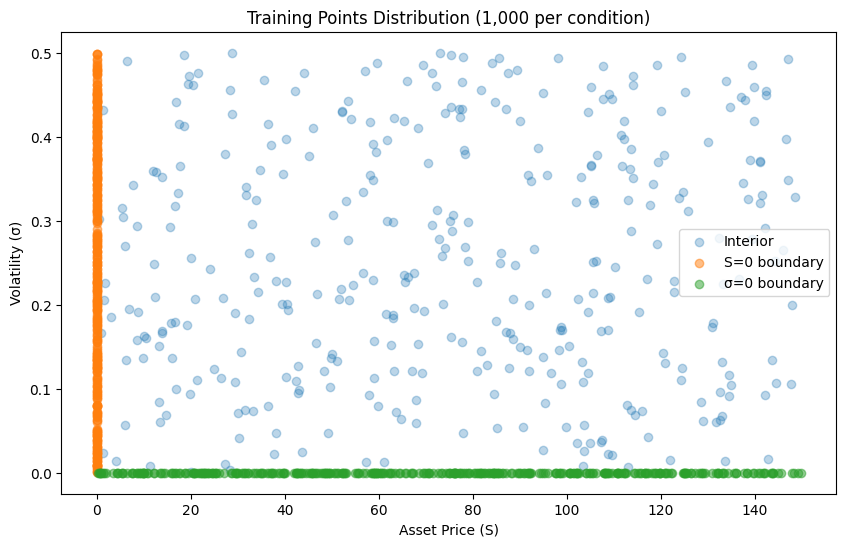

In [ ]:
def generate_points_per_condition(N=1000, S_min=0.0, S_max=150.0,
                                sigma_min=0.0, sigma_max=0.5, t=1.0):
    """
    Generates 1,000 random points for each:
    - Interior domain
    - S=0 boundary
    - S=S_max boundary
    - σ=0 boundary
    - σ=σ_max boundary
    - Initial condition (t=T)
    """
    # --- Interior points (S, σ, t all random) ---
    S_int = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigma_int = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_int = torch.rand(N, 1) * t
    interior = torch.cat([S_int, sigma_int, t_int], dim=1)

    # --- Boundary: S=0 (σ and t random) ---
    S0 = torch.zeros(N, 1)
    sigma_S0 = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_S0 = torch.rand(N, 1) * t
    bd_S0 = torch.cat([S0, sigma_S0, t_S0], dim=1)

    # --- Boundary: S=S_max (σ and t random) ---
    Smax = torch.ones(N, 1) * S_max
    sigma_Smax = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_Smax = torch.rand(N, 1) * t
    bd_Smax = torch.cat([Smax, sigma_Smax, t_Smax], dim=1)

    # --- Boundary: σ=0 (S and t random) ---
    S_sigma0 = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigma0 = torch.zeros(N, 1)
    t_sigma0 = torch.rand(N, 1) * t
    bd_sigma0 = torch.cat([S_sigma0, sigma0, t_sigma0], dim=1)

    # --- Boundary: σ=σ_max (S and t random) ---
    S_sigmamax = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigmamax = torch.ones(N, 1) * sigma_max
    t_sigmamax = torch.rand(N, 1) * t
    bd_sigmamax = torch.cat([S_sigmamax, sigmamax, t_sigmamax], dim=1)

    # --- Initial condition: t=T (S and σ random) ---
    S_initial = torch.rand(N, 1) * (S_max - S_min) + S_min
    sigma_initial = torch.rand(N, 1) * (sigma_max - sigma_min) + sigma_min
    t_initial = torch.zeros(N, 1)
    initial = torch.cat([S_initial, sigma_initial, t_initial], dim=1)

    # Combine all (total points = 6*N)
    all_points = torch.cat([
        interior, bd_S0, bd_Smax, bd_sigma0, bd_sigmamax, initial
    ], dim=0).requires_grad_(True)

    return {
        'interior': interior,
        'bd_S0': bd_S0,
        'bd_Smax': bd_Smax,
        'bd_sigma0': bd_sigma0,
        'bd_sigmamax': bd_sigmamax,
        'initial': initial,
        'all': all_points
    }

# Generate 1,000 points per condition
data = generate_points_per_condition(N=365)

# Verify
print(f"Total points: {len(data['all'])}")
print(f"Interior: {len(data['interior'])} points (S∈[{data['interior'][:,0].min():.1f}, {data['interior'][:,0].max():.1f}])")
print(f"S=0 boundary: {len(data['bd_S0'])} points (σ∈[{data['bd_S0'][:,1].min():.1f}, {data['bd_S0'][:,1].max():.1f}])")
print(f"σ=0 boundary: {len(data['bd_sigma0'])} points (S∈[{data['bd_sigma0'][:,0].min():.1f}, {data['bd_sigma0'][:,0].max():.1f}])")

# Plot S-σ distribution
plt.figure(figsize=(10, 6))
plt.scatter(data['interior'][:,0], data['interior'][:,1], label='Interior', alpha=0.3)
plt.scatter(data['bd_S0'][:,0], data['bd_S0'][:,1], label='S=0 boundary', alpha=0.5)
plt.scatter(data['bd_sigma0'][:,0], data['bd_sigma0'][:,1], label='σ=0 boundary', alpha=0.5)
plt.xlabel("Asset Price (S)"), plt.ylabel("Volatility (σ)")
plt.title("Training Points Distribution (1,000 per condition)")
plt.legend()
plt.show()

# ***PDE AND PINN CONDITIONS***

In [ ]:
# Define a function to compute the partial derivatives needed for the SABR PDE
def compute_derivatives(model, S, sigma, t):
    inputs = torch.cat([S, sigma, t], dim=1)
    C = model(inputs)

    # Compute partial derivatives using autograd
    C_S = torch.autograd.grad(C, S, grad_outputs=torch.ones_like(C), create_graph=True)[0]
    C_sigma = torch.autograd.grad(C, sigma, grad_outputs=torch.ones_like(C), create_graph=True)[0]
    C_t = torch.autograd.grad(C, t, grad_outputs=torch.ones_like(C), create_graph=True)[0]

    C_SS = torch.autograd.grad(C_S, S, grad_outputs=torch.ones_like(C_S), create_graph=True)[0]
    C_sigmasigma = torch.autograd.grad(C_sigma, sigma, grad_outputs=torch.ones_like(C_sigma), create_graph=True)[0]
    C_Ssigma = torch.autograd.grad(C_S, sigma, grad_outputs=torch.ones_like(C_S), create_graph=True)[0]

    return C, C_S, C_sigma, C_t, C_SS, C_Ssigma, C_sigmasigma

    # Define the SABR PDE
def sabr_pde(model, S, sigma, t, beta, nu, rho, r):
    C, C_S, C_sigma, C_t, C_SS, C_Ssigma, C_sigmasigma = compute_derivatives(model, S, sigma, t)

    # Compute the terms of the SABR PDE
    term1 = C_t
    term2 = 0.5 * sigma**2 * S**(2*beta) * C_SS
    term3 = rho * nu * (sigma**2) * S**beta * C_Ssigma
    term4 = 0.5 * nu**2 * (sigma**2) * C_sigmasigma
    term5 = r * S * C_S
    term6 = -r * C

    # SABR PDE that equal to zero
    residual = term1 + term2 + term3 + term4 + term5 + term6
    return residual

def IC_european_call(S, K):
    val = torch.maximum(S - K, torch.tensor(0.0))
    return val.view(-1, 1).requires_grad_(True)

# Define boundary conditions
def Smin_conditions(model, inputs_S_min):
    # Boundary condition for S = S_min
    boundary_S_min = model(inputs_S_min)  # V(t, F_min, alpha) = 0
    boundary_S_min = torch.mean(boundary_S_min**2)

    return boundary_S_min

# Define boundary conditions
def Smax_conditions2(model,  inputs_S_max):
    # Boundary condition for S = S_max
    fSmax = inputs_S_max[:, 0].requires_grad_(True).reshape(-1, 1)
    V_S_max = model(inputs_S_max)
    V_S_max_dx = torch.autograd.grad(V_S_max, inputs_S_max, torch.ones_like(V_S_max), create_graph=True)[0]
    dVdS = V_S_max_dx[:, 0].reshape(-1, 1)
    boundary_S_max = dVdS - 1  # ∂V/∂F = 1
    boundary_S_max = torch.mean(boundary_S_max**2)
    return boundary_S_max

    # Define boundary conditions
def Smax_conditions(model,  inputs_S_max):
    # Boundary condition for S = S_max
    fSmax = inputs_S_max[:, 0].requires_grad_(True).reshape(-1, 1)
    V_S_max = model(inputs_S_max)
    V_S_max_dx = torch.autograd.grad(V_S_max, inputs_S_max, torch.ones_like(V_S_max), create_graph=True)[0]
    V_S_max_d2x = torch.autograd.grad(V_S_max_dx, inputs_S_max, torch.ones_like(V_S_max_dx), create_graph=True)[0]
    dSmaxd2x = V_S_max_d2x[:, 0].reshape(-1, 1)
    boundary_S_max = torch.mean(dSmaxd2x**2)
    return boundary_S_max

# Define boundary conditions
def v0_conditions(model, inputs_v_min, K, r):
    # Boundary condition for alpha = 0
    Vmin_S = inputs_v_min[:, 0].reshape(-1, 1)
    Vmin_t = inputs_v_min[:, 2].reshape(-1, 1)
    V_v_min = model(inputs_v_min)
    V_v_min_dt = torch.autograd.grad(V_v_min, inputs_v_min, torch.ones_like(V_v_min), create_graph=True)[0]
    dVmindt = V_v_min_dt[:, 2].reshape(-1, 1)
    #boundary_alpha_min = V_alpha_min_dt
    boundary_v_min = V_v_min - torch.maximum(Vmin_S - K*torch.exp(-r*Vmin_t), torch.tensor(0.0))
    boundary_v_min = torch.mean(boundary_v_min**2)

    return boundary_v_min

# Define boundary conditions
def Vmax_conditions(model, inputs_v_max, beta):
    Vmax_S = inputs_v_max[:, 0].reshape(-1, 1)
    Vmax = inputs_v_max[:, 1].reshape(-1, 1)
    Vmax_t = inputs_v_max[:, 2].reshape(-1, 1)

    # Boundary condition for alpha = alpha_max
    V_v_max = model(inputs_v_max)

    V_v_max_dt = torch.autograd.grad(V_v_max, inputs_v_max, torch.ones_like(V_v_max), create_graph=True)[0]
    dVmaxdt = V_v_max_dt[:, 2].reshape(-1, 1)

    V_v_max_dx = torch.autograd.grad(V_v_max, inputs_v_max,  torch.ones_like(V_v_max), create_graph=True)[0]
    dVmaxdx = V_v_max_dx[:, 0].reshape(-1, 1)

    V_v_max_d2x = torch.autograd.grad(V_v_max_dx, inputs_v_max, torch.ones_like(V_v_max_dx), create_graph=True)[0]
    dVmaxd2x = V_v_max_d2x[:, 0].reshape(-1, 1)

    boundary_v_max = dVmaxdt + 0.5 * Vmax**2 * (Vmax_S**(2*beta)) * dVmaxd2x  # Combined condition
    boundary_v_max = torch.mean(boundary_v_max**2)

    return boundary_v_max

def ame_condition(model, inputs_ame, K):
    # American Option
    # Early Exercise Condition (C ≥ max(S-K,0))

    fS = inputs_ame[:, 0].requires_grad_(True).reshape(-1, 1)

    C = model(inputs)
    exercise_value = torch.maximum(fS - K, torch.tensor(0.0))
    bnd_ame_early = torch.mean(torch.relu(exercise_value - C)**2)  # Penalty if C < intrinsic value

    return bnd_ame_early


# ***ANALYTICAL BS - MONTE CARLO***

In [ ]:
# ANALYTICAL BS OPTION PRICE

def black_scholes_option_price(S, K, T, r, sigma, option_type='call'):

    # Calculate d1 and d2
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T+0.00000001))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        # Calculate the price of a European call option
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        # Calculate the price of a European put option
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")

    return option_price

# MONTE CARLO OPTION PRICE

def sabr_european_call_mc(S0_array, sigma0_array, T_array, K, r,
                          beta, nu, rho, N, M, confidence=0.95):

    S0_array = np.asarray(S0_array).flatten()
    sigma0_array = np.asarray(sigma0_array).flatten()
    T_array = np.asarray(T_array).flatten()

    n_samples = len(S0_array)
    prices = np.zeros(n_samples)
    conf_intervals = []

    z_score = norm.ppf(1 - (1 - confidence) / 2)

    for i in range(n_samples):
        S0 = S0_array[i]
        alpha0 = sigma0_array[i]
        T = T_array[i]
        dt = T / N
        sqrt_dt = np.sqrt(dt)

        # Initialize arrays
        S = np.zeros((M, N+1))
        alpha = np.zeros((M, N+1))
        S[:, 0] = S0
        alpha[:, 0] = alpha0

        for t in range(N):
            z1 = np.random.randn(M)
            z2 = np.random.randn(M)
            dW1 = z1
            dW2 = rho * z1 + np.sqrt(1 - rho**2) * z2

            alpha[:, t+1] = alpha[:, t] + nu * alpha[:, t] * dW2 * sqrt_dt
            S[:, t] = np.maximum(S[:, t], 1e-12)
            sigma_S = alpha[:, t] * (S[:, t]**(beta))
            mu_S = r * S[:, t]
            S[:, t+1] = S[:, t] + mu_S * dt + sigma_S * dW1 * sqrt_dt
            #S[:, t+1] = S[:, t]  + sigma_S * dW1 * sqrt_dt

        # Call option payoff
        payoffs = np.maximum(S[:, -1] - K, 0)
        discounted = np.exp(-r * T) * payoffs

        mean_price = np.mean(discounted)
        prices[i] = mean_price

    return prices


# ***CALIBRATION***

In [ ]:
def sabr_volatility(alpha, beta, rho, nu, F, K, T):
    """ Computes the SABR model implied volatility using Hagan's formula """
    if F == K:  # ATM case
        FK_beta = F**(1 - beta)
        vol = alpha / FK_beta * (1 + (((1 - beta) ** 2) / 24 * (alpha**2 / FK_beta**2) +
                                     (1 / 4) * (rho * beta * nu * alpha / FK_beta) +
                                     ((2 - 3 * rho**2) / 24) * (nu**2)) * T)
    else:
        z = (nu / alpha) * (F * K) ** ((1 - beta) / 2) * np.log(F / K)
        x_z = np.log((np.sqrt(1 - 2 * rho * z + z**2) + z - rho) / (1 - rho))
        FK_beta = (F * K) ** ((1 - beta) / 2)
        term1 = (1 + ((((1-beta)**2)/24)*((alpha**2)/FK_beta**2) +
                     (1 / (4*FK_beta)) * (rho * beta * nu * alpha) +
                     ((2 - 3 * rho**2) / 24) * (nu**2)) * T)
        term2 = (1 + ((((1 - beta) ** 2) / 24) * ((np.log(F/K)) ** 2)) +
                 ((((1 - beta) ** 4) / 1920) * ((np.log(F/K)) ** 4)))
        vol = (alpha / FK_beta) * (z / x_z) * term1 / term2
    return vol

# Loss function to minimize
def sabr_loss(params, F, strikes, T, market_vols):
    alpha, beta, rho, nu = params
    model_vols = np.array([sabr_volatility(alpha, beta, rho, nu, F, K, T) for K in strikes])
    return np.sum((model_vols - market_vols) ** 2)

# ***CALLING REAL DATASET***

In [ ]:
# Load all sheets in the Excel file
excel_file = "/content/drive/MyDrive/Bitirme_real_dataset/american_options.xlsx"
sheet_names = pd.ExcelFile(excel_file).sheet_names  # All sheet names in the Excel file

results_MC_df = pd.DataFrame(columns=["Sheet", "SABR Model MSE", "SABR Model MAPE"])

prediction_df = pd.DataFrame()

output_dir = "/content/drive/MyDrive/Bitirme_real_dataset/new/ame/1kepoch1k200n"
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

# ***TRAINING***

In [ ]:
for sheet_name in sheet_names:
    print(f"Processing sheet: {sheet_name}")
    # Load data for the current sheet
    df = pd.read_excel(excel_file, sheet_name=sheet_name)

    F = df['close'].values  # SPOT PRICE
    spot_price = df['close'].iloc[0]
    sigma = df['implied_volatility'].values
    K = df['strike'].values
    market_prices = df['Option_mid'].values
    time = df['Remaining_day'].values / 252

    # Initial guess for SABR parameters
    initial_guess = [sigma[0], 1, 0.0, 0.3]

    # Optimize SABR parameters
    result_parameters = minimize(sabr_loss, initial_guess, args=(F[0], K, time[0], sigma),
                              bounds=[(0.01, 1), (0, 1), (-0.99, 0.99), (0.01, None)])
        # Optimize SABR parameters

    alfa, beta, rho, nu = result_parameters.x

    print("Optimized SABR parameters:")
    print("Alpha:", alfa)
    print("Beta:", beta)
    print("Rho:", rho)
    print("Nu:", nu)

    F_torch = torch.tensor(F, dtype=torch.float32, requires_grad=True).view(-1, 1)
    sigma_torch = torch.tensor(sigma, dtype=torch.float32, requires_grad=True).view(-1, 1)

    F_min, F_max = torch.min(F_torch).item(), torch.max(F_torch).item()
    v_min, v_max = torch.min(sigma_torch).item(), torch.max(sigma_torch).item()

    r=0.0007

    lambda1, lambda2 = 1, 1

    model = Alternative_FCN()
    optimizer = torch.optim.Adam(model.parameters(),lr=2e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=200,
        verbose=True,
        min_lr=2e-5)

    best_loss = float('inf')
    save_path = 'best_model.pth'

    totallosses=[]
    Lic_list = []
    Lpde_list = []
    Lbd_list = []
    Lbd_Smax_list = []
    Lbd_Smin_list = []
    Lbd_Vmax_list = []
    Lbd_V0_list = []

    for i in range(1000):
        data = generate_points_per_condition(N=1000, S_min=0.0, S_max=1.2*F_max,
                                    sigma_min=0.0, sigma_max=1.1*v_max, t=1.0)

        t0 = data['initial'].clone().detach().requires_grad_(True)
        V0 = data['bd_sigma0'].clone().detach().requires_grad_(True)
        S0 = data['bd_S0'].clone().detach().requires_grad_(True)
        Smax = data['bd_Smax'].clone().detach().requires_grad_(True)
        vmax = data['bd_sigmamax'].clone().detach().requires_grad_(True)
        inputs = data['interior'].clone().detach().requires_grad_(True)
        inputs_all = data['all'].clone().detach().requires_grad_(True)


        C0 = model(t0)
        loss1 = (torch.squeeze(C0) - IC_european_call(t0[:,0].requires_grad_(True).reshape(-1, 1), K[0]))**2
        Lic = lambda1 * loss1.mean()

        # Compute the PDE residual as the loss
        residual = sabr_pde(model, inputs[:,0].requires_grad_(True).reshape(-1, 1), inputs[:,1].requires_grad_(True).reshape(-1, 1), inputs[:,2].requires_grad_(True).reshape(-1, 1), beta, nu, rho, r)
        Lpde = lambda2 *torch.mean(torch.relu(-residual)**2)  #AMERICAN OPTION COND. (C-max(S-K, 0)) >= 0 , pde >= 0

        bnd_early = ame_condition(model, inputs, K[0])

        bnd_S_min = Smin_conditions(model, S0)

        bnd_S_max = Smax_conditions(model, Smax)

        bnd_v_min = v0_conditions(model, V0, K[0], r)

        bnd_v_max = Vmax_conditions(model, vmax, beta)

        Lbd = ( 10*bnd_S_max + 100*bnd_v_max + 10000*bnd_v_min + 1*bnd_S_min + bnd_early )
        Lic2 = 0.0000015*Lic
        Lpde2 = Lpde
        loss = Lic2 + Lpde2 + Lbd

        loss.backward(retain_graph=True)
        optimizer.step()
        scheduler.step(loss)
        optimizer.zero_grad()

        totallosses.append(loss.item())
        Lic_list.append(Lic2.item())
        Lpde_list.append(Lpde2.item())
        Lbd_list.append(Lbd.item())

        if i % 100 == 0:
            print(f"Iteration {i}, Loss: {loss.item()}")
            print(f"Loss-1 (IC): {Lic2.item()}, Loss-2 (pde): {Lpde2.item()} , Loss-5 (bd): {Lbd.item()}")
            current_lr = optimizer.param_groups[0]['lr']
            print(f'LR: {current_lr:.2e}')

        # En iyi model
        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': best_loss,
                'iteration': i
                }, save_path)

    print("best loss: ", best_loss )

    checkpoint = torch.load("best_model.pth")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Model {checkpoint['iteration']} iterasyondan yüklendi, Loss: {checkpoint['loss']:.6f}")

    F_torch = torch.tensor(F, dtype=torch.float32, requires_grad=True).view(-1, 1)
    sigma_torch = torch.tensor(sigma, dtype=torch.float32, requires_grad=True).view(-1, 1)
    time_torch = torch.tensor(time, dtype=torch.float32, requires_grad=True).view(-1, 1)
    inputs_sabr = torch.cat([F_torch, sigma_torch, time_torch], dim=1)

    C = model(inputs_sabr) # PINN OPTION PRICES
    C = C.detach().numpy()

    bs_op_pr = black_scholes_option_price(F, K[0], time, r, sigma) # ANALYTICAL BS OPTION PRICES

    mc = sabr_european_call_mc(F, sigma, time, K[0], r, beta, nu, rho, N=100, M=10000, confidence=0.95) # MONTE CARLO OPTIONS PRİCES

    plt.plot(time, C, label="SABR-PINN", linestyle='dashed')
    plt.plot(time, bs_op_pr, label="Analytical BS Values")
    plt.plot(time, mc, label="Monte Carlo Values")
    plt.xlabel("Time (t)")
    plt.ylabel("Option Price (C)")
    plt.legend()
    plot_path = os.path.join(output_dir, f"{sheet_name}_option_price_plot_time.png")
    plt.savefig(plot_path)
    plt.close()
    plt.show()

    mse1 = np.mean((mc - C.ravel())**2)
    mape1 = np.mean(np.abs((mc - C.ravel()) / mc))
    print("MSE between MC and PINN:", mse1)
    print("MAPE between MC and PINN::", mape1)

    new_row = pd.DataFrame({
    "Sheet": [sheet_name],
    "SABR Model MSE": [mse1],
    "SABR Model MAPE": [mape1],
    })

    results_MC_df = pd.concat([results_MC_df, new_row], ignore_index=True)

    prediction_df[f'SABR_{sheet_name}'] = pd.Series(C.flatten())



Processing sheet: A
Optimized SABR parameters:
Alpha: 0.39532095046376325
Beta: 0.976724798751423
Rho: 0.018544715903049656
Nu: 0.2932543331343732


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Iteration 0, Loss: 3051118.25
Loss-1 (IC): 0.00043367594480514526, Loss-2 (pde): 1.5965033739462342e-08 , Loss-5 (bd): 3051118.25
LR: 2.00e-04
Iteration 100, Loss: 15918.615234375
Loss-1 (IC): 0.00043403953895904124, Loss-2 (pde): 0.12157513201236725 , Loss-5 (bd): 15918.4931640625
LR: 2.00e-04
Iteration 200, Loss: 1980.5989990234375
Loss-1 (IC): 0.0004248057084623724, Loss-2 (pde): 0.24573858082294464 , Loss-5 (bd): 1980.352783203125
LR: 2.00e-04
Iteration 300, Loss: 765.0671997070312
Loss-1 (IC): 0.0004209580656606704, Loss-2 (pde): 0.5560359954833984 , Loss-5 (bd): 764.5107421875
LR: 2.00e-04
Iteration 400, Loss: 658.365966796875
Loss-1 (IC): 0.0004512509040068835, Loss-2 (pde): 0.6771738529205322 , Loss-5 (bd): 657.6883544921875
LR: 2.00e-04
Iteration 500, Loss: 647.6044311523438
Loss-1 (IC): 0.0004292765515856445, Loss-2 (pde): 0.6207081079483032 , Loss-5 (bd): 646.9832763671875
LR: 2.00e-04
Iteration 600, Loss: 472.4583740234375
Loss-1 (IC): 0.00044898479245603085, Loss-2 (pde): 

/tmp/ipython-input-3332182183.py:177: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_MC_df = pd.concat([results_MC_df, new_row], ignore_index=True)


Optimized SABR parameters:
Alpha: 0.4217032239383481
Beta: 0.9683485937138233
Rho: 0.031230566746666445
Nu: 0.2909128438363357


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Iteration 0, Loss: 301582560.0
Loss-1 (IC): 0.04972285032272339, Loss-2 (pde): 0.0029866229742765427 , Loss-5 (bd): 301582560.0
LR: 2.00e-04
Iteration 100, Loss: 40497380.0
Loss-1 (IC): 0.03772033378481865, Loss-2 (pde): 5.496869087219238 , Loss-5 (bd): 40497376.0
LR: 2.00e-04
Iteration 200, Loss: 18810794.0
Loss-1 (IC): 0.04061003029346466, Loss-2 (pde): 365.43145751953125 , Loss-5 (bd): 18810428.0
LR: 2.00e-04
Iteration 300, Loss: 9058487.0
Loss-1 (IC): 0.04890773445367813, Loss-2 (pde): 552.4882202148438 , Loss-5 (bd): 9057934.0
LR: 2.00e-04
Iteration 400, Loss: 6113078.5
Loss-1 (IC): 0.04820007458329201, Loss-2 (pde): 629.4431762695312 , Loss-5 (bd): 6112449.0
LR: 2.00e-04
Iteration 500, Loss: 605346.0625
Loss-1 (IC): 0.050970979034900665, Loss-2 (pde): 745.8363647460938 , Loss-5 (bd): 604600.1875
LR: 2.00e-04
Iteration 600, Loss: 190347.84375
Loss-1 (IC): 0.05198654904961586, Loss-2 (pde): 628.4107666015625 , Loss-5 (bd): 189719.375
LR: 2.00e-04
Iteration 700, Loss: 164119.0625
Lo

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Iteration 0, Loss: 1140989440.0
Loss-1 (IC): 0.15650136768817902, Loss-2 (pde): 0.25691601634025574 , Loss-5 (bd): 1140989440.0
LR: 2.00e-04
Iteration 100, Loss: 90043984.0
Loss-1 (IC): 0.116212397813797, Loss-2 (pde): 223.528564453125 , Loss-5 (bd): 90043760.0
LR: 2.00e-04
Iteration 200, Loss: 80635640.0
Loss-1 (IC): 0.13199388980865479, Loss-2 (pde): 1277.4324951171875 , Loss-5 (bd): 80634360.0
LR: 2.00e-04
Iteration 300, Loss: 74659904.0
Loss-1 (IC): 0.12421973049640656, Loss-2 (pde): 2851.816162109375 , Loss-5 (bd): 74657056.0
LR: 2.00e-04
Iteration 400, Loss: 63089052.0
Loss-1 (IC): 0.12350180000066757, Loss-2 (pde): 18151.02734375 , Loss-5 (bd): 63070900.0
LR: 2.00e-04
Iteration 500, Loss: 47794464.0
Loss-1 (IC): 0.13657903671264648, Loss-2 (pde): 12703.818359375 , Loss-5 (bd): 47781760.0
LR: 2.00e-04
Iteration 600, Loss: 46643772.0
Loss-1 (IC): 0.1353503167629242, Loss-2 (pde): 16109.5458984375 , Loss-5 (bd): 46627664.0
LR: 2.00e-04
Iteration 700, Loss: 52720072.0
Loss-1 (IC): 0

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Iteration 0, Loss: 2242643.0
Loss-1 (IC): 0.00032899717916734517, Loss-2 (pde): 4.068444781069047e-08 , Loss-5 (bd): 2242643.0
LR: 2.00e-04
Iteration 100, Loss: 4796.17724609375
Loss-1 (IC): 0.00027902331203222275, Loss-2 (pde): 0.007223289459943771 , Loss-5 (bd): 4796.169921875
LR: 2.00e-04
Iteration 200, Loss: 1354.822265625
Loss-1 (IC): 0.00029872392769902945, Loss-2 (pde): 0.0672043040394783 , Loss-5 (bd): 1354.7547607421875
LR: 2.00e-04
Iteration 300, Loss: 941.248779296875
Loss-1 (IC): 0.00028528139228001237, Loss-2 (pde): 0.1334783434867859 , Loss-5 (bd): 941.114990234375
LR: 2.00e-04
Iteration 400, Loss: 639.1859130859375
Loss-1 (IC): 0.00029130739858374, Loss-2 (pde): 0.15127919614315033 , Loss-5 (bd): 639.0343627929688
LR: 2.00e-04
Iteration 500, Loss: 399.7803955078125
Loss-1 (IC): 0.0002872328332159668, Loss-2 (pde): 0.14029595255851746 , Loss-5 (bd): 399.6398010253906
LR: 2.00e-04
Iteration 600, Loss: 324.0952453613281
Loss-1 (IC): 0.00030039710691198707, Loss-2 (pde): 0.1

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Iteration 0, Loss: 8333698.0
Loss-1 (IC): 0.0013184171402826905, Loss-2 (pde): 5.731853434554068e-06 , Loss-5 (bd): 8333698.0
LR: 2.00e-04
Iteration 100, Loss: 316418.5
Loss-1 (IC): 0.001265383674763143, Loss-2 (pde): 1.7523916959762573 , Loss-5 (bd): 316416.75
LR: 2.00e-04
Iteration 200, Loss: 3651.420166015625
Loss-1 (IC): 0.0013468011748045683, Loss-2 (pde): 2.056025743484497 , Loss-5 (bd): 3649.36279296875
LR: 2.00e-04
Iteration 300, Loss: 2276.742431640625
Loss-1 (IC): 0.0013313187519088387, Loss-2 (pde): 2.4419546127319336 , Loss-5 (bd): 2274.299072265625
LR: 2.00e-04
Iteration 400, Loss: 1905.056640625
Loss-1 (IC): 0.0013469851110130548, Loss-2 (pde): 3.4428794384002686 , Loss-5 (bd): 1901.6124267578125
LR: 2.00e-04
Iteration 500, Loss: 6241.84375
Loss-1 (IC): 0.001344461226835847, Loss-2 (pde): 2.9020354747772217 , Loss-5 (bd): 6238.9404296875
LR: 2.00e-04
Iteration 600, Loss: 1936.3280029296875
Loss-1 (IC): 0.0012618950568139553, Loss-2 (pde): 3.605050802230835 , Loss-5 (bd): 

# ***SAVING***

In [ ]:
# Save results to an Excel file
results_file = "/content/drive/MyDrive/Bitirme_real_dataset/new/ame/1kepoch1k200n/MSE_MAPE_Results_analytic.xlsx"
results_MC_df.to_excel(results_file, index=False)
print(f"Results saved to {results_file}")


# Save results to an Excel file
results_file2 = "/content/drive/MyDrive/Bitirme_real_dataset/new/ame/1kepoch1k200n/Predictions.xlsx"
prediction_df.to_excel(results_file2, index=False)
print(f"Results saved to {results_file2}")